In [3]:
import json

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import LancasterStemmer

def stemSentence(sentence):
    stemmer = LancasterStemmer()
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [5]:
import re
def preprocessing(line):
    line = re.sub(r'[^a-zA-z.?!]', ' ', line)
    line = re.sub(r'[ ]+', ' ', line)
    return line

In [6]:
vocab_size = 10000
embedding_dim = 16
max_length = 200
trunc_type='post'
padding_type='post' 
oov_tok = "<OOV>"
training_size = 100000
total_size = 1000000

In [7]:
import pandas as pd

data = pd.read_csv('train-balanced-sarcasm.csv', usecols=['comment','label','score'], index_col=False)
data = data.reindex(columns=['comment','label','score'])
data.dropna(inplace=True)
data = data.sort_values(by='score', ascending=False)
sentences = data['comment']
labels = data['label']
data.head()

,comment,label,score
143497,That's exactly what a country who made up a ho...,1,9070
157472,but it still snows,1,7563
110228,"lol, you can't make this stuff up.",0,5818
53985,He didn't drink the compliance,0,5629
689739,"In the Half Life series, the reason Gordon Fre...",0,5163


In [8]:
sentences = sentences[:training_size].apply(preprocessing)
sentences = sentences[:training_size].apply(stemSentence)
sentences.head()

143497    that s exact what a country who mad up a hoax ...
157472                                    but it stil snow 
110228                    lol you can t mak thi stuff up . 
53985                           he didn t drink the comply 
689739    in the half lif sery the reason gordon freem d...
Name: comment, dtype: object

In [9]:
from sklearn.model_selection import train_test_split
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(sentences, labels[:training_size], test_size = 0.2)
print(training_sentences.shape, training_labels.shape)
print(testing_sentences.shape, testing_labels.shape)

(80000,) (80000,)
(20000,) (20000,)


In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [11]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=4)

In [12]:
from tensorflow.keras.layers import LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(9)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 18)                1872      
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 19        
Total params: 161,891
Trainable params: 161,891
Non-trainable params: 0
_________________________________________________________________


In [14]:
filepath="weights.best.hdf5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
callbacks_list = [cp_callback, es_callback]
history = model.fit(training_padded, training_labels, 
                    epochs=20, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/20
2500/2500 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.6634
Epoch 00001: val_accuracy improved from -inf to 0.69395, saving model to weights.best.hdf5
2500/2500 [==============================] - 273s 109ms/step - loss: 0.6116 - accuracy: 0.6634 - val_loss: 0.5786 - val_accuracy: 0.6939
Epoch 2/20
2500/2500 [==============================] - ETA: 0s - loss: 0.5617 - accuracy: 0.7188
Epoch 00002: val_accuracy improved from 0.69395 to 0.69825, saving model to weights.best.hdf5
2500/2500 [==============================] - 269s 107ms/step - loss: 0.5617 - accuracy: 0.7188 - val_loss: 0.5748 - val_accuracy: 0.6982
Epoch 3/20
2500/2500 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.7383
Epoch 00003: val_accuracy did not improve from 0.69825
2500/2500 [==============================] - 297s 119ms/step - loss: 0.5391 - accuracy: 0.7383 - val_loss: 0.5817 - val_accuracy: 0.6924


In [15]:
model.load_weights("weights.best.hdf5")

In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

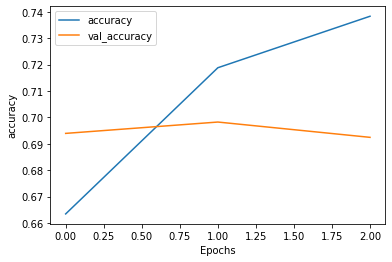

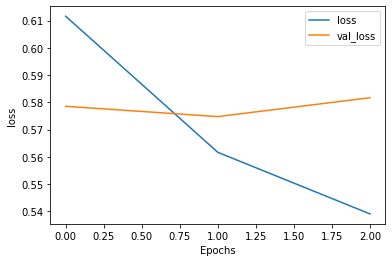

In [17]:
#CNN MODEL STATS
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [18]:
model.save('model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


In [19]:
tf.keras.models.load_model('model')

In [20]:
sentence = input("sentence: ")
stemmed = stemSentence(sentence)
sequences = tokenizer.texts_to_sequences([stemmed])
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Sarcasm' if model.predict(padded)[0][0]>0.5 else 'Not Sarcasm')

sentence: Silence is gold but duct tape is silver
Sarcasm
